## Comparison of Win Loss ratios for cities in each league within the USA big 4 (NBA, NHL, NFL, MLB)

This notebook is derived from my final assignment in the [Introduction to Data Science with Python]() course offered by the University of Michigan on Coursera.

For this assignment, I was given a file of metropolitan regions and associated sports teams from [wikipedia_data.html](wikipedia_data.html). Each of these regions may have one or more teams from the "Big 4": NFL (football, in [nfl.csv](nfl.csv)), MLB (baseball, in [mlb.csv](mlb.csv)), NBA (basketball, in [nba.csv](nba.csv) or NHL (hockey, in [nhl.csv](nhl.csv)).

The main question I had to answer via my code was : **What is the `win/loss ratio`'s correlation with the `population` of the city it is in?**

`Win/Loss ratio` refers to the number of wins over the number of wins plus the number of losses. 
Correlation will be computed with the `pearson` method.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
%matplotlib inline

In [4]:
def adding_cleaned_teams(league, pattern):
    
    '''
    Returns a DataFrame whose columns are the city, its population and a team from this city in the specified league.
    Each row of this DataFrame corresponds to a team from a city.
    A city can have several teams and can thereore appear several times in the rows.
    
    Args:
        league: League (NBA, NFL, MLB or NHL) where teams names should be extracted from.

    Returns:
        DataFrame with Metropolitan area, population and [league] team as columns
        
    '''
    
    # Use the previously defined pattern to extract team names
    
    teams = cities[league].str.extract(pattern)
    
    # Concatenate it with Metropolitan area and population columns
    df = pd.concat([cities[['Metropolitan area', 'Population']], teams], axis=1)

    
    df = (df
          .set_index(['Metropolitan area', 'Population'])  # To stack only the three teams columns thus stay with only one
          .stack()
          .reset_index()                                   # Bring back the columns indexed to the dataframe
          .rename(columns={0: 'team'})                     # Rename the column obtained by stacking
          [['Metropolitan area', 'Population', 'team']]    # Keep relevant columns

         )
    
    return df

In [5]:
def WL_ratio_per_city(league_df, league, cities_df):
    
    '''
    Returns a DataFrame of metropolitan areas with their population and average Win/loss ratio.
    Group by metropolitan areas and calculate the average of the W/L ratios of each team in the same city
    
    Args:
        league_df: DataFrame of Win/Loss ratios of every team in the chosen league
        cities_df: DataFrame of metropolitan areas and their respective teams and population
    
    Returns:
        DataFrame with Metropolitan area, average W/L and population as columns
        
    '''
    
    # To get the Win loss ratio for all metropolitan areas, we must perform a join
    # between cities_df and league_df on 'team'
    # We should therefore first have the same format in the team columns
    # This dictionnary helps formatting teams in league_df
    
    dic = {league_df[league_df['team'].str.contains(team)].index[0]: team for team in cities_df['team']}
    league_df['team'] = pd.Series(dic)
    
    
    # Put Population's column to an integer dtype
    cities_df['Population'] = cities_df['Population'].astype('int64')
    
    
    # Add Metropolitan area and Population to the league df and group by Metrop. Area
    grouped_df=(
        pd.merge(cities_df, league_df, on='team')[['Metropolitan area', 'Population', 'team', league + '_ratio']]
        .groupby('Metropolitan area').mean()
    )
    
    return grouped_df

## Loading Data

In [6]:
cities = pd.read_html('wikipedia_data.html')[1]
cities.head()

,Metropolitan area,Country,Pop.rank,Population (2016 est.)[8],B4,NFL,MLB,NBA,NHL,B6,MLS,CFL
0,New York City,United States,1,20153634,9,GiantsJets[note 1],YankeesMets[note 2],KnicksNets,RangersIslandersDevils[note 3],11,Red BullsNew York City FC,—
1,Los Angeles,United States,2,13310447,8,RamsChargers[note 4],DodgersAngels,LakersClippers,KingsDucks,10,GalaxyLos Angeles FC[note 5],—
2,San Francisco Bay Area,United States,6,6657982,6,49ersRaiders[note 6],GiantsAthletics,Warriors,Sharks[note 7],7,Earthquakes,—
3,Chicago,United States,3,9512999,5,Bears[note 8],CubsWhite Sox,Bulls[note 9],Blackhawks,6,Fire,—
4,Dallas–Fort Worth,United States,4,7233323,4,Cowboys,Rangers,Mavericks,Stars,5,FC Dallas,—


Let's rename the population column and keep relevant columns. We are only interested in the BIG 4 leagues : NHL, NBA, NFL and MLB

In [7]:
cities = cities.rename(columns={'Population (2016 est.)[8]': 'Population'})[['Metropolitan area', 'Population',
                                                                             'NHL', 'NBA', 'NFL', 'MLB']]

I should clean up the team columns (NFL, MLB, NBA, NHL), **in order to properly join** with other DataFrames later.

**Main Observation: Cities with multiple teams have all of those team names stacked together in the same string.**

- The first group of my regular expression is taking the first team of each string, which always starts with a capital letter or numbers (49ers for example) and can be a 1-word name or a 2-word name (In this case there is a whitespace between those words).

- Other groups would retrieve the names of other teams if there are any (we observe that there are a maximum of 3 teams per city). That's why I use the same pattern as the first team and add a '?' to state that this group may or may not exist.

- The last group is intended to remove the noisy "[note]" added at the end of the names of some teams.

In [24]:
team_pattern = '([A-Z0-9]+[a-z]+(?: [A-Z0-9]+[a-z]+)?)' # First group retrieving a first team

team2and3 = (team_pattern + '?') * 2                # Possibly (with the '?'') second and third teams

noise = '(?:\[.*\])?'                               # Match strings with the noisy "[note]"

whole_pattern = team_pattern + team2and3 + noise    # Concatenate all groups


# Example on NHL's team column to check if the pattern retrieves well the teams
cities['NHL'].str.extract(whole_pattern).head()

,0,1,2
0,Rangers,Islanders,Devils
1,Kings,Ducks,NaN
2,Sharks,NaN,NaN
3,Blackhawks,NaN,NaN
4,Stars,NaN,NaN


We now use this pattern and the function adding_cleaned_teams to create DataFrames with **proper team columns.**

In [25]:
cities_nhl = adding_cleaned_teams('NHL', whole_pattern)
cities_nba = adding_cleaned_teams('NBA', whole_pattern) 
cities_mlb = adding_cleaned_teams('MLB', whole_pattern)
cities_nfl = adding_cleaned_teams('NFL', whole_pattern) 

cities_nba.head()

,Metropolitan area,Population,team
0,New York City,20153634,Knicks
1,New York City,20153634,Nets
2,Los Angeles,13310447,Lakers
3,Los Angeles,13310447,Clippers
4,San Francisco Bay Area,6657982,Warriors


### Loading and cleaning NHL, NBA, MLB and NFL datasets 

In [26]:
nhl = pd.read_csv('nhl.csv')
nhl.head(4)

,team,GP,W,L,OL,PTS,PTS%,GF,GA,SRS,SOS,RPt%,ROW,year,League
0,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division,2018,NHL
1,Tampa Bay Lightning*,82,54,23,5,113,.689,296,236,0.66,-0.07,.634,48,2018,NHL
2,Boston Bruins*,82,50,20,12,112,.683,270,214,0.62,-0.07,.610,47,2018,NHL
3,Toronto Maple Leafs*,82,49,26,7,105,.640,277,232,0.49,-0.06,.567,42,2018,NHL


In [27]:
# Keep data for 2018 only and relevant columns
nhl = nhl[nhl['year'] == 2018][['team','GP','W']]

# Remove rows about the division (as the row 0)
nhl.drop([0,9,18,26], inplace=True)

# Compute the W/L Ratio for each team
nhl['NHL_ratio'] = nhl['W'].astype('int64') / nhl['GP'].astype('int64')

# Use the function WL_ratio_per_city created above to generate a dataframe with W/L ratios for each city (not teams)
cities_WL_nhl = WL_ratio_per_city(nhl, 'NHL', cities_nhl)
cities_WL_nhl.head(3)

,Population,NHL_ratio
Metropolitan area,,
Boston,4794447,0.609756
Buffalo,1132804,0.304878
Calgary,1392609,0.451220


Let's do the same for nba, mlb and nfl datasets.

In [28]:
nba = pd.read_csv('nba.csv')
mlb = pd.read_csv('mlb.csv')
nfl = pd.read_csv('nfl.csv')

In [29]:
# Keep data for 2018 only and relevant columns
nba = nba[nba['year'] == 2018][['team','W', 'L']]
mlb = mlb[mlb['year'] == 2018][['team','W', 'L']]

nfl.drop([0,5,10,15,20,25,30,35], inplace=True)
nfl = nfl[nfl['year'] == 2018][['team','W', 'L']]

# Compute W/L ratios
nba['NBA_ratio'] = nba['W'].astype('int64') / (nba['W'].astype('int64') + nba['L'].astype('int64'))
mlb['MLB_ratio'] = mlb['W'].astype('int64') / (mlb['W'].astype('int64') + mlb['L'].astype('int64'))
nfl['NFL_ratio'] = nfl['W'].astype('int64') / (nfl['W'].astype('int64') + nfl['L'].astype('int64'))

In [30]:
cities_WL_nba = WL_ratio_per_city(nba, 'NBA', cities_nba)
cities_WL_mlb = WL_ratio_per_city(mlb, 'MLB', cities_mlb)
cities_WL_nfl = WL_ratio_per_city(nfl, 'NFL', cities_nfl)

### Comparing Win/Loss Ratios between cities

Let's visualize the win loss ratio rank of each city in each league within BIG 4.

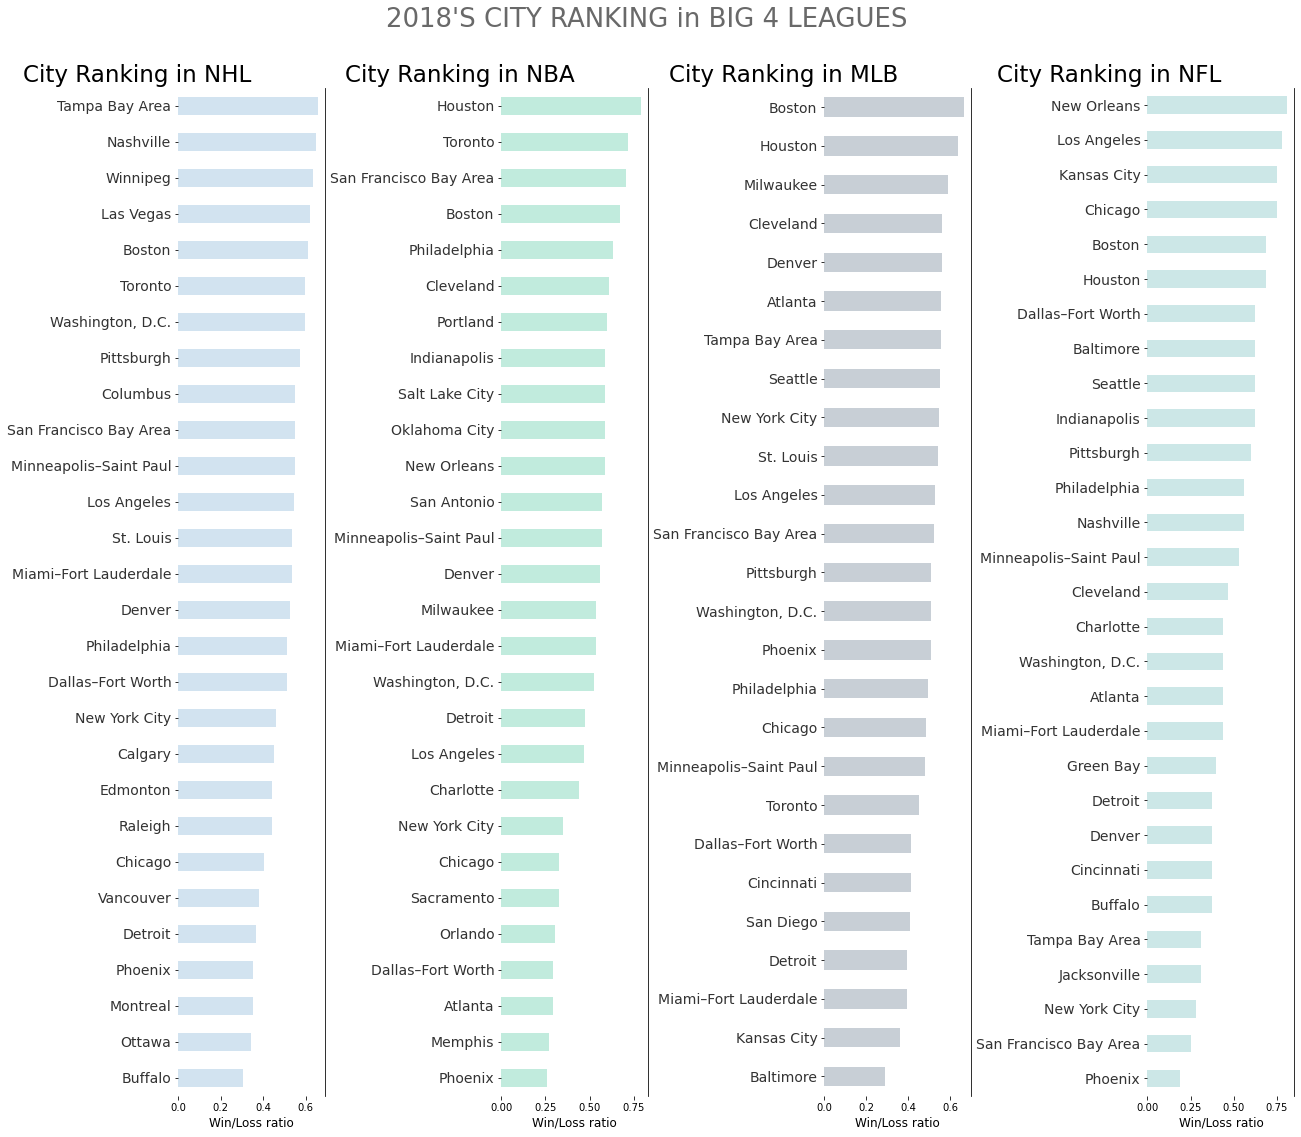

In [31]:
fig, axes = plt.subplots(1, 4, figsize=(20,16))   # Create the figure to plot on
fig.subplots_adjust(wspace=1.2, top=1)

# Sort values of W/L ratio in each league to get a ranking
cities_WL_nhl.sort_values(by = 'NHL_ratio', inplace=True)
cities_WL_nba.sort_values(by = 'NBA_ratio', inplace=True)
cities_WL_mlb.sort_values(by = 'MLB_ratio', inplace=True)
cities_WL_nfl.sort_values(by = 'NFL_ratio', inplace=True)

# Plot each league's ranking with a horizontal bar plot
cities_WL_nhl[['NHL_ratio']].plot.barh(ax=axes[0],  alpha=0.2, legend=False, title='City Ranking in NHL')
cities_WL_nba[['NBA_ratio']].plot.barh(ax=axes[1], alpha=0.4, color='mediumaquamarine', legend=False, title='City Ranking in NBA')
cities_WL_mlb[['MLB_ratio']].plot.barh(ax=axes[2], alpha=0.4, color ='lightslategrey', legend=False, title='City Ranking in MLB')
cities_WL_nfl[['NFL_ratio']].plot.barh(ax=axes[3], alpha=0.2, color='darkcyan', legend=False, title='City Ranking in NFL')


# Formatting subplots
for axe in axes:
    axe.set_ylabel("")
    axe.set_xlabel("Win/Loss ratio", fontsize=12)
    axe.set_yticklabels(axe.get_yticklabels(), fontsize=14, color='k', alpha=0.8)
    axe.set_title(axe.get_title(), fontsize=23, color='k', ha='right')
    
    axe.spines['left'].set_visible(False)    # Make left, top and bottom lines of grids invisible, only right lines remain
    axe.spines['top'].set_visible(False)
    axe.spines['bottom'].set_visible(False)

# Figure title
fig.suptitle("2018'S CITY RANKING in BIG 4 LEAGUES", x= 0.45, y=1.07, fontsize=26, color='dimgrey');

### Correlation between population and  W/L ratio of a city

To answer the question we were given at the start : **What is the `win/loss ratio`'s correlation with the `population` of the city it is in?**

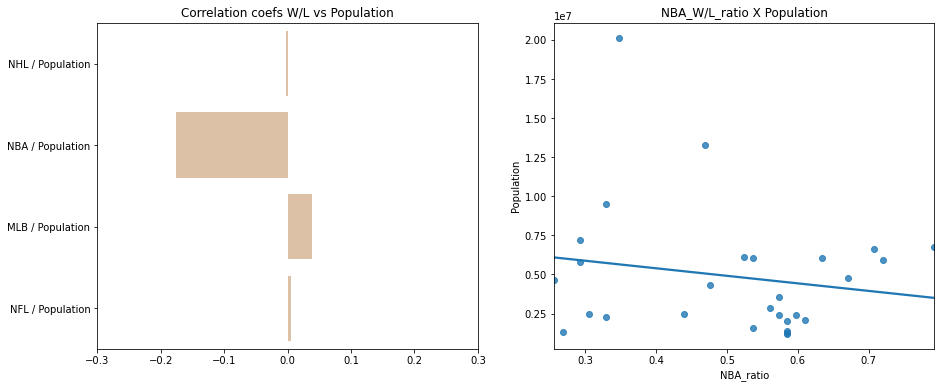

In [32]:
# Compute correlation coefficients ('pearson' method) between win/loss ratios and the population of a city
corr = [cities_WL_nhl['NHL_ratio'].corr(cities_WL_nhl['Population']),
        cities_WL_nba['NBA_ratio'].corr(cities_WL_nba['Population']),
        cities_WL_mlb['MLB_ratio'].corr(cities_WL_nhl['Population']),
        cities_WL_nfl['NFL_ratio'].corr(cities_WL_nfl['Population'])]

# Create the figure to plot on
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Visualize each correlation coef with a horizontal bar plot
ylabels = pd.Series(['NHL', 'NBA', 'MLB', 'NFL']) + ' / Population'
sns.barplot(x=corr, y=ylabels, color='peru', alpha=0.5, orient='h', ax=axes[0])
sns.regplot(x='NBA_ratio', y='Population', data=cities_WL_nba, ax=axes[1], ci=None)

# Formatting subplots
axes[0].set_xlim([-0.3, 0.3])
axes[0].set_title('Correlation coefs W/L vs Population')
axes[1].set_title('NBA_W/L_ratio X Population');

We can clearly see that in general there is a poor correlation between both variables. The highest magnitude of the coefficients is around 0.17. 
However, this coefficient has got a negative sign (then -0.17), which assumes an opposite growth between both variables `NBA_WL_ratio` and `Population`.
